# LAHIS — Language Attention Head Importance Scores
### Llama-2-7B × TED Multilingual Data

This notebook reproduces the LAHIS method from the paper  
**"Focusing on Language: Revealing and Exploiting Language Attention Heads in Multilingual LLMs"**  
applied to **Llama-2-7B** using **TED talk transcripts** as the multilingual corpus.

---
**Steps:**
1. Prepare TED data (per-language text files)
2. Load Llama-2-7B with LAHIS head-mask patch
3. Compute importance matrices for each language
4. Visualise heatmaps (Fig 1 equivalent)
5. Identify language-specific and language-general heads
6. Specificity validation — the dark diagonal (Fig 2 equivalent)
7. Cross-lingual intervention demo

## 0 · Setup

In [1]:
# Install dependencies if not already installed
import subprocess, sys
pkgs = ["datasets", "transformers", "torch", "tqdm", "matplotlib", "huggingface_hub", "python-dotenv"]
subprocess.run([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

CompletedProcess(args=['/opt/miniconda3/envs/MV00/bin/python', '-m', 'pip', 'install', '-q', 'datasets', 'transformers', 'torch', 'tqdm', 'matplotlib', 'huggingface_hub', 'python-dotenv'], returncode=0)

In [2]:
import os, sys, json, torch
import matplotlib
matplotlib.use('Agg')   # must be set before pyplot import
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image
from tqdm.notebook import tqdm as tqdm_nb   # notebook-style progress bars

# ── working directory: always run from LAHIS/src/ so all relative paths work ──
NOTEBOOK_DIR = os.path.abspath('')          # wherever the notebook lives
SRC_DIR      = os.path.join(NOTEBOOK_DIR, 'src')
os.chdir(SRC_DIR)
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

print('Working directory:', os.getcwd())
print('Python         :', sys.version.split()[0])
print('PyTorch        :', torch.__version__)
print('MPS available  :', torch.backends.mps.is_available())
print('CUDA available :', torch.cuda.is_available())

Working directory: /Users/eleftheria/Desktop/Lahis-implimentation/LAHIS/src
Python         : 3.13.7
PyTorch        : 2.9.1
MPS available  : True
CUDA available : False


In [3]:
# ── Configuration — edit these if needed ──────────────────────────────────────

# Languages to analyse (all have good TED coverage)
LANGUAGES = ['en', 'fr', 'es', 'zh', 'ru', 'de', 'ar', 'ja', 'ko', 'vi']

# Device: 'mps' for Apple Silicon, 'cuda' for NVIDIA, 'cpu' as fallback
if torch.backends.mps.is_available():
    DEVICE = 'mps'
elif torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print('Using device:', DEVICE)

# Number of TED samples per language for importance matrix computation
# 1000 is the paper default; use 200 for a quick first run
DATA_NUM    = 1000
MAX_LENGTH  = 256    # token limit per sample (reduce to 128 if you hit memory issues)

# Paths
TED_JSONL   = '../../TED2025/multi_way.jsonl'
DATA_DIR    = '../data/ted'
RESULTS_DIR = '../results/llama2'
HEATMAP_DIR = '../results/llama2/heatmaps'

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(HEATMAP_DIR, exist_ok=True)
print('Paths OK')

Using device: mps
Paths OK


## 1 · Prepare TED Data
Converts the raw `multi_way.jsonl` into one JSON file per language.  
Each file is a list of `{"text": "..."}` chunks (5 sentences joined together).  
**Skip this cell if you already ran `ted_loader.py`.**

In [4]:
import ted_loader as TED

# Check which languages already have data files
missing = [l for l in LANGUAGES if not os.path.exists(os.path.join(DATA_DIR, f'ted_{l}.json'))]

if not missing:
    print('All TED data files already exist — skipping.')
else:
    print(f'Building data for: {missing}')
    records = TED.load_ted_jsonl(TED_JSONL)
    print(f'Loaded {len(records):,} TED records')
    streams = TED.build_monolingual_streams(records, missing, join_n_sentences=5)
    TED.save_monolingual_json(streams, DATA_DIR)
    print('Done.')

# Show summary
print('\nData files:')
for lang in LANGUAGES:
    path = os.path.join(DATA_DIR, f'ted_{lang}.json')
    if os.path.exists(path):
        size = os.path.getsize(path) // (1024*1024)
        print(f'  {lang:6s}  {size:4d} MB  {path}')
    else:
        print(f'  {lang:6s}  MISSING')

All TED data files already exist — skipping.

Data files:
  en        78 MB  ../data/ted/ted_en.json
  fr        54 MB  ../data/ted/ted_fr.json
  es        63 MB  ../data/ted/ted_es.json
  zh        13 MB  ../data/ted/ted_zh.json
  ru        71 MB  ../data/ted/ted_ru.json
  de        29 MB  ../data/ted/ted_de.json
  ar        86 MB  ../data/ted/ted_ar.json
  ja        23 MB  ../data/ted/ted_ja.json
  ko        40 MB  ../data/ted/ted_ko.json
  vi        56 MB  ../data/ted/ted_vi.json


## 2 · Load Llama-2-7B
Downloads the model from HuggingFace on first run (~14 GB, cached afterwards).  
The LAHIS head-mask patch is applied automatically.

In [5]:
import model_handler

model, tokenizer = model_handler.load_model(
    'llama2',
    device=DEVICE,
    half_precision=True,   # bfloat16 — needs ~14 GB
    local=False,           # download from HuggingFace
)
model.eval()

NUM_LAYERS = model.config.num_hidden_layers
NUM_HEADS  = model.config.num_attention_heads
print(f'\nModel: {NUM_LAYERS} layers × {NUM_HEADS} heads = {NUM_LAYERS*NUM_HEADS} total heads')
print('LAHIS patch applied:', hasattr(model.model.layers[0].self_attn, '_lahis_mask'))

`torch_dtype` is deprecated! Use `dtype` instead!


Load model in torch.bfloat16


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Applying LAHIS head-mask patch to Llama-2 attention layers...
  Patch applied.

Model: 32 layers × 32 heads = 1024 total heads
LAHIS patch applied: True


## 3 · Compute LAHIS Importance Matrices
For each language, run a forward+backward pass over TED text samples.  
The gradient of the soft head mask gives the importance of each head for that language.

**Output:** `../results/llama2/llama2_{lang}.pth` — a `[32 × 32]` tensor per language.

Already-computed languages are skipped automatically.

In [6]:
from attn_matrix_ted import get_attn_head_matrix_ted

importance_matrices = {}   # lang -> [32, 32] tensor

for lang in LANGUAGES:
    out_path = os.path.join(RESULTS_DIR, f'llama2_{lang}.pth')
    
    if os.path.exists(out_path):
        print(f'[{lang}] Loading cached matrix from {out_path}')
        importance_matrices[lang] = torch.load(out_path, map_location='cpu').float()
        m = importance_matrices[lang]
        print(f'      Score range: [{m.min():.2f}, {m.max():.2f}]')
    else:
        print(f'\n[{lang}] Computing importance matrix ({DATA_NUM} samples)...')
        matrix = get_attn_head_matrix_ted(
            model, tokenizer,
            lan=lang,
            model_name='llama2',
            data_dir=DATA_DIR,
            data_num=DATA_NUM,
            max_length=MAX_LENGTH,
        )
        importance_matrices[lang] = matrix.float()

print(f'\n✓ Matrices ready for {list(importance_matrices.keys())}')

[en] Loading cached matrix from ../results/llama2/llama2_en.pth
      Score range: [0.00, 344.07]

[fr] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[fr] Using 1000 samples from ../data/ted/ted_fr.json


LAHIS [fr]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_fr.pth
  Score range: [-2.8323, 203.5836]

[es] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[es] Using 1000 samples from ../data/ted/ted_es.json


LAHIS [es]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_es.pth
  Score range: [-5.3740, 240.5342]

[zh] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[zh] Using 1000 samples from ../data/ted/ted_zh.json


LAHIS [zh]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_zh.pth
  Score range: [-3.6873, 76.1967]

[ru] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[ru] Using 1000 samples from ../data/ted/ted_ru.json


LAHIS [ru]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_ru.pth
  Score range: [-3.5110, 257.6340]

[de] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[de] Using 1000 samples from ../data/ted/ted_de.json


LAHIS [de]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_de.pth
  Score range: [-6.3883, 249.7726]

[ar] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[ar] Using 1000 samples from ../data/ted/ted_ar.json


LAHIS [ar]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_ar.pth
  Score range: [-2.8093, 55.0531]

[ja] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[ja] Using 1000 samples from ../data/ted/ted_ja.json


LAHIS [ja]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_ja.pth
  Score range: [-3.2041, 53.7244]

[ko] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[ko] Using 1000 samples from ../data/ted/ted_ko.json


LAHIS [ko]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_ko.pth
  Score range: [-2.2853, 125.6519]

[vi] Computing importance matrix (1000 samples)...


Generating train split: 0 examples [00:00, ? examples/s]

[vi] Using 1000 samples from ../data/ted/ted_vi.json


LAHIS [vi]:   0%|          | 0/1000 [00:00<?, ?it/s]

  Saved importance matrix  ->  ../results/llama2/llama2_vi.pth
  Score range: [-1.0214, 50.6781]

✓ Matrices ready for ['en', 'fr', 'es', 'zh', 'ru', 'de', 'ar', 'ja', 'ko', 'vi']


## 4 · Heatmaps — Figure 1
Each cell in the grid is one attention head. Brighter = more important for that language.  
Language-specific heads appear as bright spots that differ between languages.

Saved → ../results/llama2/heatmaps/all_languages.png


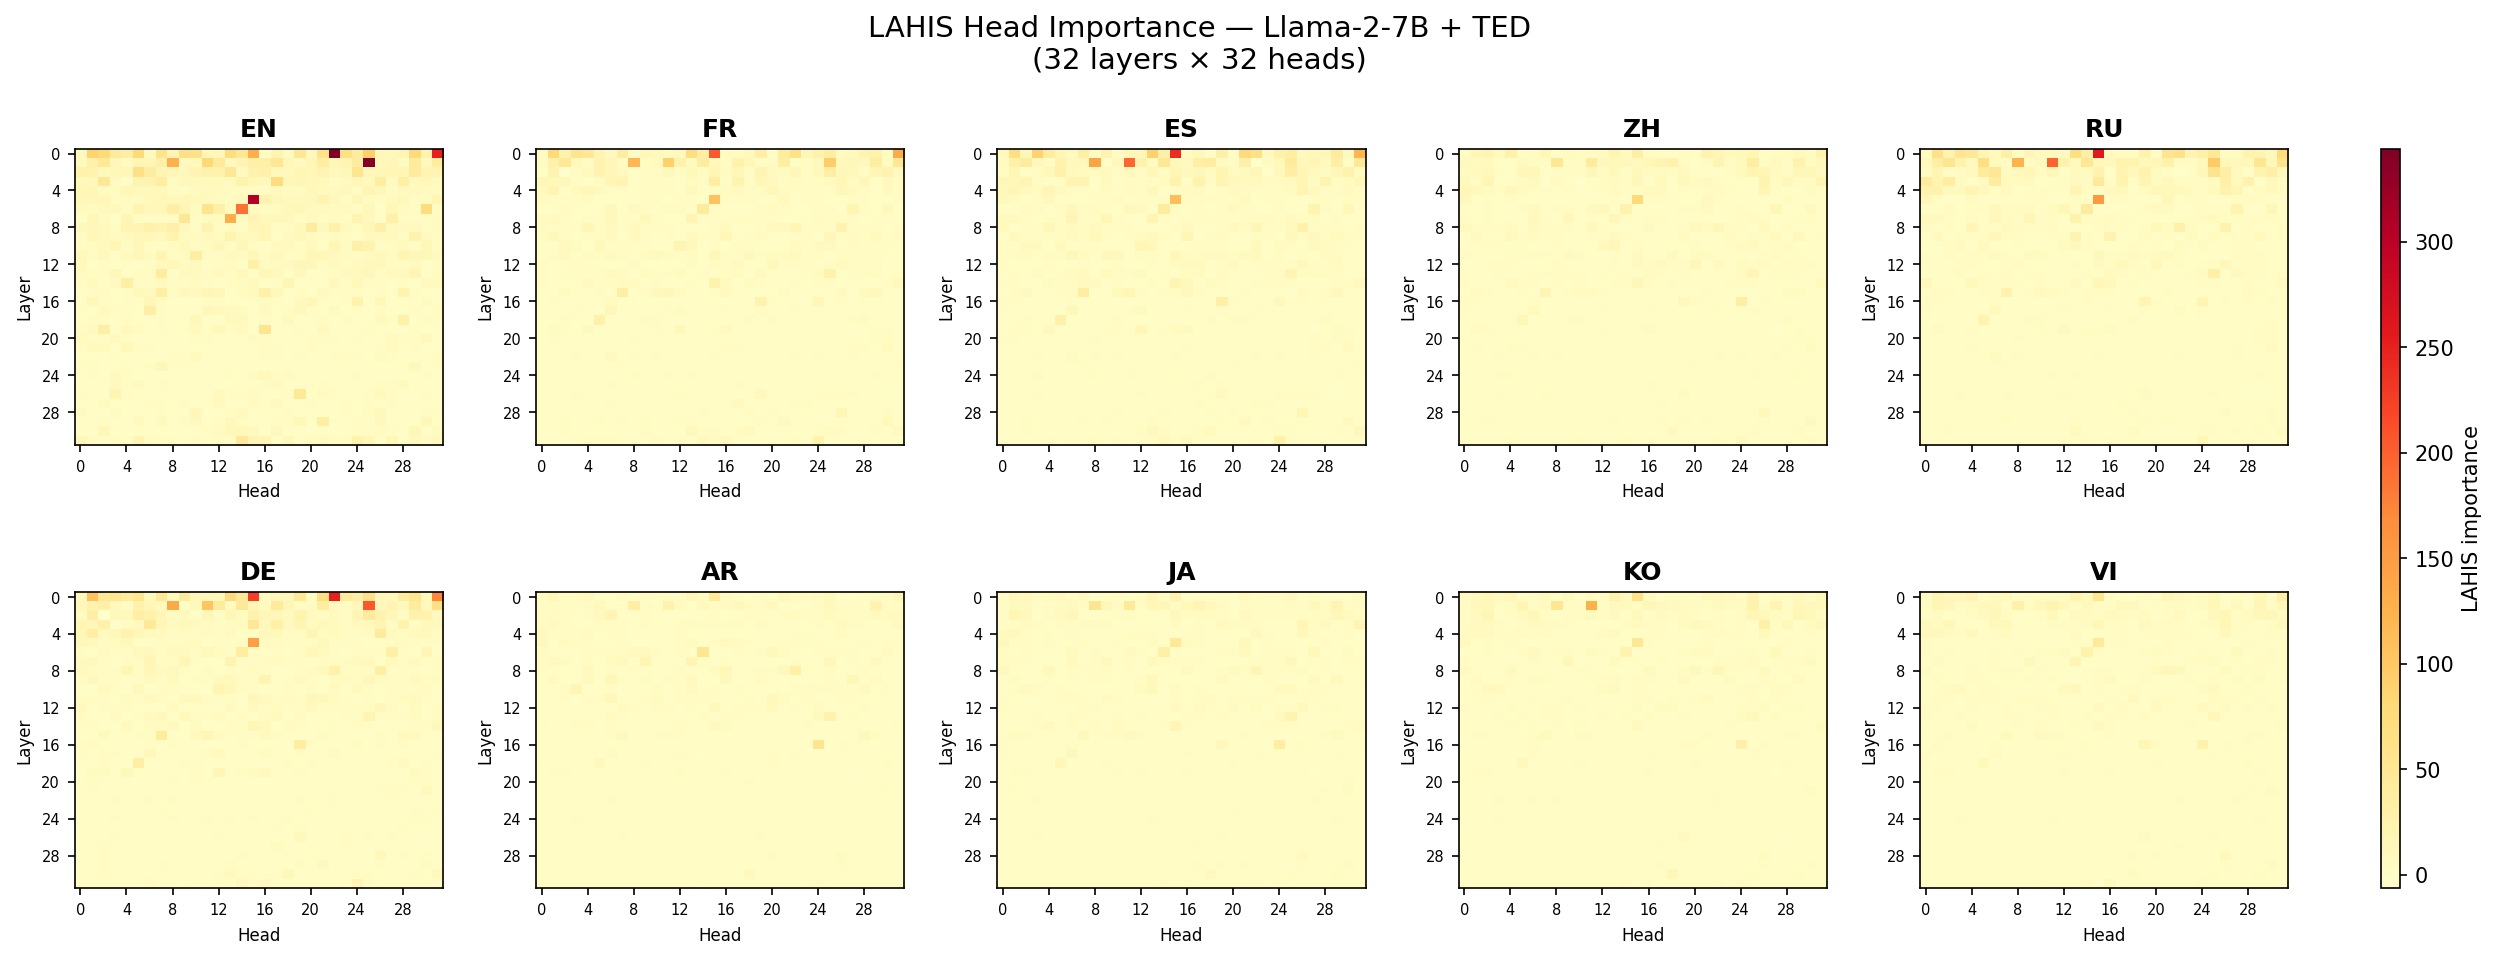

In [7]:
import numpy as np
import matplotlib.gridspec as gridspec

langs_with_matrices = list(importance_matrices.keys())
n      = len(langs_with_matrices)
ncols  = min(n, 5)
nrows  = (n + ncols - 1) // ncols

# Shared colour scale across all languages
all_vals = torch.cat([importance_matrices[l].view(-1) for l in langs_with_matrices])
vmin, vmax = all_vals.min().item(), all_vals.max().item()

fig = plt.figure(figsize=(ncols * 4, nrows * 3.2))
gs  = gridspec.GridSpec(nrows, ncols + 1,
                        width_ratios=[1]*ncols + [0.05],
                        hspace=0.5, wspace=0.3)

last_im = None
for i, lang in enumerate(langs_with_matrices):
    row, col = divmod(i, ncols)
    ax  = fig.add_subplot(gs[row, col])
    mat = importance_matrices[lang].numpy()
    
    last_im = ax.imshow(mat, aspect='auto', cmap='YlOrRd',
                        vmin=vmin, vmax=vmax, origin='upper')
    ax.set_title(lang.upper(), fontsize=12, fontweight='bold')
    ax.set_xlabel('Head', fontsize=8)
    ax.set_ylabel('Layer', fontsize=8)
    ax.set_xticks(range(0, NUM_HEADS, 4))
    ax.set_yticks(range(0, NUM_LAYERS, 4))
    ax.tick_params(labelsize=7)

# Hide unused subplots
for j in range(len(langs_with_matrices), nrows * ncols):
    row, col = divmod(j, ncols)
    fig.add_subplot(gs[row, col]).axis('off')

cbar_ax = fig.add_subplot(gs[:, ncols])
fig.colorbar(last_im, cax=cbar_ax, label='LAHIS importance')
fig.suptitle(f'LAHIS Head Importance — Llama-2-7B + TED\n({NUM_LAYERS} layers × {NUM_HEADS} heads)',
             fontsize=14, y=1.02)

heatmap_path = os.path.join(HEATMAP_DIR, 'all_languages.png')
fig.savefig(heatmap_path, dpi=150, bbox_inches='tight')
plt.close(fig)

print(f'Saved → {heatmap_path}')
display(Image(heatmap_path))

## 5 · Head Distribution by Layer
For each language, where (in which layers) do the top-2% most important heads cluster?

Saved → ../results/llama2/heatmaps/head_distribution.png


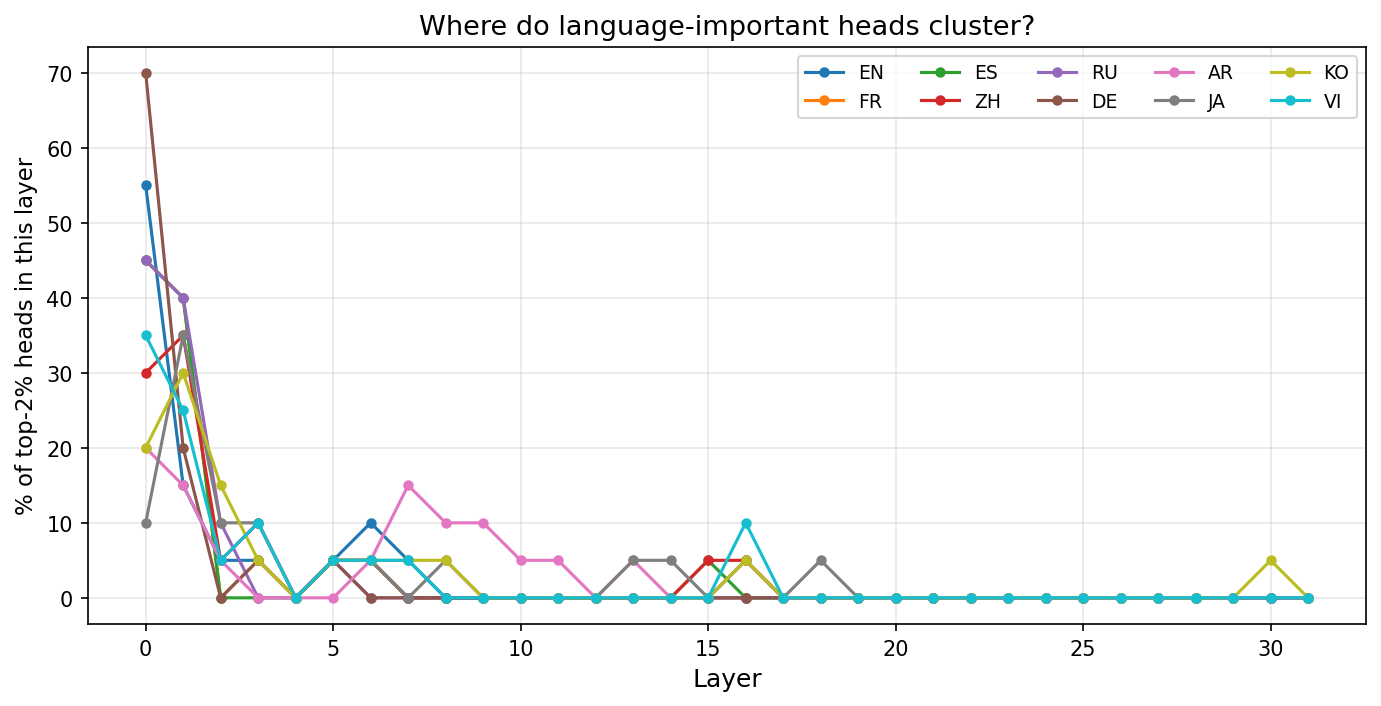

In [8]:
TOP_P = 0.02   # top 2% of heads
n_top = max(1, int(NUM_LAYERS * NUM_HEADS * TOP_P))

fig, ax = plt.subplots(figsize=(11, 5))

for lang in langs_with_matrices:
    matrix = importance_matrices[lang]
    _, topk_idx = torch.topk(matrix.view(-1), k=n_top)
    
    layer_counts = torch.zeros(NUM_LAYERS, dtype=torch.int)
    for idx in topk_idx.tolist():
        l, _ = divmod(idx, NUM_HEADS)
        layer_counts[l] += 1
    
    pct = (layer_counts.float() / layer_counts.sum() * 100).numpy()
    ax.plot(range(NUM_LAYERS), pct, '-o', markersize=4, label=lang.upper())

ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel(f'% of top-{int(TOP_P*100)}% heads in this layer', fontsize=11)
ax.set_title('Where do language-important heads cluster?', fontsize=13)
ax.legend(ncol=5, fontsize=9)
ax.grid(alpha=0.3)

dist_path = os.path.join(HEATMAP_DIR, 'head_distribution.png')
fig.savefig(dist_path, dpi=150, bbox_inches='tight')
plt.close(fig)

print(f'Saved → {dist_path}')
display(Image(dist_path))

## 6 · Language-Specific and Language-General Heads
- **Language-specific heads:** top-2% for one language, NOT in the top-2% for most other languages.
- **Language-general heads:** appear in the top-2% for the majority of languages (likely handle universal grammar/syntax).

In [9]:
from collections import Counter

Q       = 1.0 - TOP_P   # quantile threshold (0.98 = top 2%)
MIN_REP = max(2, len(langs_with_matrices) - 1)  # appear in N-1 languages = general

# Collect top-p% indices per language
sorted_head_list = []
for lang in langs_with_matrices:
    flat      = importance_matrices[lang].view(-1).float()
    threshold = torch.quantile(flat, q=Q)
    topk_idx  = (flat > threshold).nonzero(as_tuple=False).squeeze()
    if topk_idx.dim() == 0:
        topk_idx = topk_idx.unsqueeze(0)
    vals  = flat[topk_idx]
    order = torch.argsort(vals, descending=True)
    sorted_head_list.append(topk_idx[order])

# Language-general = appear in top-p% for MIN_REP+ languages
all_indices  = torch.cat(sorted_head_list).tolist()
index_counts = Counter(all_indices)
general_heads = [
    idx for idx, cnt in sorted(index_counts.items(), key=lambda x: -x[1])
    if cnt >= MIN_REP
]

# Language-specific = top-p% for this language, minus general heads
general_set    = set(general_heads)
specific_heads = {}
for lang, topk in zip(langs_with_matrices, sorted_head_list):
    specific_heads[lang] = [idx for idx in topk.tolist() if idx not in general_set]

# Save
with open(os.path.join(RESULTS_DIR, 'head_indices.json'), 'w') as f:
    json.dump(specific_heads, f, indent=2)
with open(os.path.join(RESULTS_DIR, 'repeated_indices.json'), 'w') as f:
    json.dump(general_heads, f, indent=2)

print(f'Language-general heads (in top-2% for {MIN_REP}+ languages): {len(general_heads)}')
general_layer_head = [(idx // NUM_HEADS, idx % NUM_HEADS) for idx in general_heads[:10]]
print(f'  First 10 (layer, head): {general_layer_head}')

print(f'\nLanguage-specific heads (top-5 per language):')
for lang in langs_with_matrices:
    top5 = [(idx // NUM_HEADS, idx % NUM_HEADS) for idx in specific_heads[lang][:5]]
    print(f'  {lang.upper():4s}: {len(specific_heads[lang]):3d} heads   top-5 (layer,head): {top5}')

Language-general heads (in top-2% for 9+ languages): 5
  First 10 (layer, head): [(0, 15), (1, 8), (1, 11), (0, 13), (5, 15)]

Language-specific heads (top-5 per language):
  EN  :  16 heads   top-5 (layer,head): [(0, 22), (1, 25), (0, 31), (6, 14), (7, 13)]
  FR  :  16 heads   top-5 (layer,head): [(0, 31), (1, 25), (0, 1), (0, 22), (0, 3)]
  ES  :  16 heads   top-5 (layer,head): [(0, 31), (0, 3), (0, 21), (0, 1), (0, 22)]
  ZH  :  16 heads   top-5 (layer,head): [(1, 25), (16, 24), (0, 4), (1, 18), (1, 29)]
  RU  :  16 heads   top-5 (layer,head): [(1, 25), (0, 31), (1, 5), (0, 1), (0, 22)]
  DE  :  16 heads   top-5 (layer,head): [(0, 22), (1, 25), (0, 31), (0, 1), (0, 21)]
  AR  :  17 heads   top-5 (layer,head): [(16, 24), (6, 14), (8, 22), (13, 25), (1, 29)]
  JA  :  16 heads   top-5 (layer,head): [(16, 24), (6, 14), (13, 25), (3, 31), (1, 17)]
  KO  :  16 heads   top-5 (layer,head): [(16, 24), (3, 26), (1, 25), (6, 14), (0, 25)]
  VI  :  16 heads   top-5 (layer,head): [(0, 31), (6, 1

## 7 · Specificity Validation — Dark Diagonal
Disable the top-2% heads for each language and measure perplexity across all languages.  
**Expected result:** disabling language X heads hurts language X the most → dark diagonal.

⚠️ This cell takes a while (it runs the model ~N² times). Use `SPEC_DATA_NUM = 100` for a quick preview.

In [10]:
import datasets as hf_datasets

SPEC_DATA_NUM = 100    # increase to 500 for paper-quality results

def ppl_with_mask(test_lang, head_mask):
    """Compute average perplexity on test_lang TED text with a given head mask."""
    data_file = os.path.join(DATA_DIR, f'ted_{test_lang}.json')
    ds = hf_datasets.load_dataset('json', data_files=data_file, split='train')
    ds = ds.shuffle(seed=37).select(range(min(SPEC_DATA_NUM, len(ds))))
    
    hm = head_mask.to(model.device).to(model.dtype)
    model_handler.set_lahis_head_mask(model, hm)
    
    total, count = 0.0, 0
    for item in ds:
        ids = tokenizer(item['text'], return_tensors='pt',
                        truncation=True, max_length=MAX_LENGTH).input_ids.to(model.device)
        with torch.no_grad():
            out = model(ids, labels=ids)
            total += torch.exp(out.loss).item()
            count += 1
    
    model_handler.clear_lahis_head_mask(model)
    return round(total / max(count, 1), 2)


# Only run for languages that have both a matrix AND a TED data file
eval_langs = [l for l in langs_with_matrices
              if os.path.exists(os.path.join(DATA_DIR, f'ted_{l}.json'))]

spec_path = os.path.join(RESULTS_DIR, 'specificity.json')

if os.path.exists(spec_path):
    print(f'Loading cached results from {spec_path}')
    with open(spec_path) as f:
        spec_results = json.load(f)
else:
    print('Computing baseline perplexity (no masking)...')
    ori_mask = torch.ones(NUM_LAYERS, NUM_HEADS)
    baseline = {l: ppl_with_mask(l, ori_mask) for l in tqdm_nb(eval_langs, desc='baseline')}
    print('Baseline PPL:', baseline)

    print('\nComputing masked perplexity (disable top-2% heads per language)...')
    masked = {}
    for head_lang in tqdm_nb(eval_langs, desc='head_lang'):
        matrix = importance_matrices[head_lang]
        n_top  = max(1, int(NUM_LAYERS * NUM_HEADS * TOP_P))
        _, topk_idx = torch.topk(matrix.view(-1), k=n_top)
        hm = torch.ones(NUM_LAYERS, NUM_HEADS)
        hm.view(-1)[topk_idx] = 0.0

        masked[head_lang] = {}
        for test_lang in eval_langs:
            masked[head_lang][test_lang] = ppl_with_mask(test_lang, hm)

    delta = {hl: {tl: round(masked[hl][tl] - baseline[tl], 2)
                  for tl in eval_langs} for hl in eval_langs}

    spec_results = {'baseline': baseline, 'masked': masked, 'delta': delta}
    with open(spec_path, 'w') as f:
        json.dump(spec_results, f, indent=2)
    print(f'\nSaved → {spec_path}')

print('Done.')

Computing baseline perplexity (no masking)...


baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Baseline PPL: {'en': 53.52, 'fr': 62.75, 'es': 73.88, 'zh': 226.58, 'ru': 152.38, 'de': 109.67, 'ar': 32.66, 'ja': 131.67, 'ko': 119.93, 'vi': 32.64}

Computing masked perplexity (disable top-2% heads per language)...


head_lang:   0%|          | 0/10 [00:00<?, ?it/s]


Saved → ../results/llama2/specificity.json
Done.


Saved → ../results/llama2/heatmaps/dark_diagonal.png


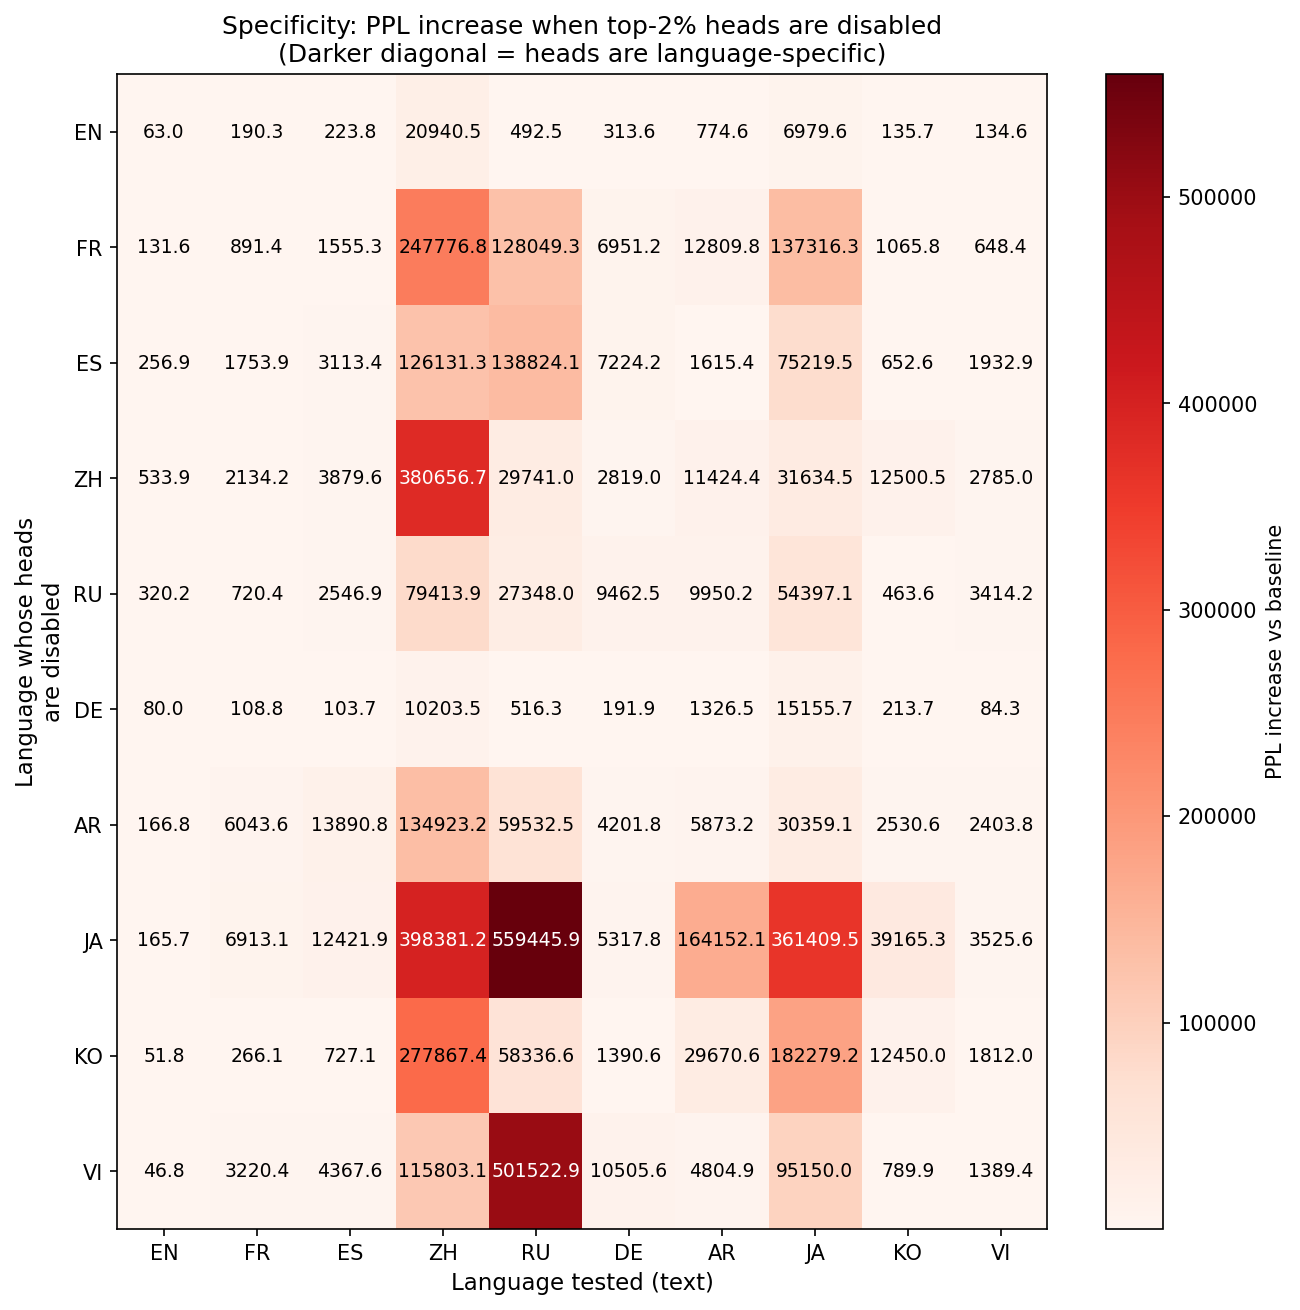

In [11]:
# ── Plot the dark diagonal ────────────────────────────────────────────────────
eval_langs = list(spec_results['delta'].keys())
n_l        = len(eval_langs)
mat        = np.array([[spec_results['delta'][hl][tl]
                        for tl in eval_langs] for hl in eval_langs])

fig, ax = plt.subplots(figsize=(max(6, n_l), max(5, n_l)))
im = ax.imshow(mat, cmap='Reds', aspect='auto')

ax.set_xticks(range(n_l))
ax.set_yticks(range(n_l))
ax.set_xticklabels([l.upper() for l in eval_langs], fontsize=10)
ax.set_yticklabels([l.upper() for l in eval_langs], fontsize=10)
ax.set_xlabel('Language tested (text)', fontsize=11)
ax.set_ylabel("Language whose heads\nare disabled", fontsize=11)
ax.set_title('Specificity: PPL increase when top-2% heads are disabled\n'
             '(Darker diagonal = heads are language-specific)', fontsize=12)

for i in range(n_l):
    for j in range(n_l):
        colour = 'white' if mat[i, j] > mat.max() * 0.6 else 'black'
        ax.text(j, i, f'{mat[i,j]:.1f}', ha='center', va='center',
                fontsize=9, color=colour)

fig.colorbar(im, ax=ax, label='PPL increase vs baseline')

dd_path = os.path.join(HEATMAP_DIR, 'dark_diagonal.png')
fig.savefig(dd_path, dpi=150, bbox_inches='tight')
plt.close(fig)

print(f'Saved → {dd_path}')
display(Image(dd_path))

## 8 · Cross-Lingual Intervention Demo
Given a prompt containing facts in two languages (A and B), enhancing language-A heads
biases the model toward the language-A answer.

**Prompt structure:** `[lang1 fact] [filler] [lang2 fact]  Alice's occupation is a`

Three conditions:
- **ori** — no intervention
- **enhance lang1** — multiply lang1-specific heads by 3
- **weaken lang2** — multiply lang2-specific heads by 0

In [12]:
# Occupation templates + vocabulary
POS_TEMPLATE = {
    'zh': 'Alice的职位是&&pos&&。',
    'fr': 'Le métier d\'Alice est &&pos&&.',
    'hi': 'ऐलिस का पेशा &&pos&& है।',
    'es': 'La profesión de Alice es &&pos&&.',
    'de': 'Alices Beruf ist &&pos&&.',
    'ru': 'Профессия Алисы — &&pos&&.',
    'ar': 'مهنة أليس هي &&pos&&.',
    'ja': 'アリスの職業は&&pos&&です。',
    'ko': '앨리스의 직업은 &&pos&&입니다.',
    'vi': 'Nghề nghiệp của Alice là &&pos&&.',
}
POS = {
    'en': ['painter', 'scientist', 'doctor', 'gardener', 'lawyer'],
    'zh': ['画家', '科学家', '医生', '园丁', '律师'],
    'fr': ['peintre', 'scientifique', 'médecin', 'jardinier', 'avocat'],
    'es': ['pintor', 'científico', 'médico', 'jardinero', 'abogado'],
    'de': ['Maler', 'Wissenschaftler', 'Arzt', 'Gärtner', 'Anwalt'],
    'ru': ['художник', 'учёный', 'врач', 'садовник', 'юрист'],
    'ar': ['رسام', 'عالم', 'طبيب', 'بستاني', 'محامٍ'],
    'ja': ['画家', '科学者', '医者', '庭師', '弁護士'],
    'ko': ['화가', '과학자', '의사', '정원사', '변호사'],
    'vi': ['họa sĩ', 'nhà khoa học', 'bác sĩ', 'người làm vườn', 'luật sư'],
}

def build_mask(lang, scale, n_heads=20):
    indices = specific_heads.get(lang, [])[:n_heads]
    mask = torch.ones(NUM_LAYERS, NUM_HEADS)
    mask.view(-1)[indices] = scale
    return mask

def generate(prompt, mask, max_new_tokens=10):
    inputs = tokenizer(prompt, return_tensors='pt',
                       truncation=True, max_length=512).to(model.device)
    hm = mask.to(model.device).to(model.dtype)
    model_handler.set_lahis_head_mask(model, hm)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=max_new_tokens,
                              pad_token_id=tokenizer.eos_token_id)
    model_handler.clear_lahis_head_mask(model)
    return tokenizer.decode(out[0], skip_special_tokens=True)[len(prompt):].strip()

print('Intervention helpers ready.')

Intervention helpers ready.


In [13]:
# ── Choose two languages that have templates ──────────────────────────────────
LAN1 = 'zh'   # change to any language in POS_TEMPLATE
LAN2 = 'fr'   # change to any language in POS_TEMPLATE

if LAN1 not in POS_TEMPLATE or LAN2 not in POS_TEMPLATE:
    print(f'No template for {LAN1} or {LAN2}. Choose from:', list(POS_TEMPLATE.keys()))
else:
    filler = ' She likes ice-cream. She always does sports at the gym in the morning. '
    ori_mask    = torch.ones(NUM_LAYERS, NUM_HEADS)
    enhance_lan1 = build_mask(LAN1, scale=3.0)
    weaken_lan2  = build_mask(LAN2, scale=0.0)

    results_rows = []
    for i in range(min(3, len(POS['en']))):
        pos1 = POS.get(LAN1, POS['en'])[i]
        pos2 = POS.get(LAN2, POS['en'])[(i+1) % len(POS['en'])]
        en1  = POS['en'][i]
        en2  = POS['en'][(i+1) % len(POS['en'])]

        prompt = (POS_TEMPLATE[LAN1].replace('&&pos&&', pos1)
                  + filler
                  + POS_TEMPLATE[LAN2].replace('&&pos&&', pos2)
                  + " Alice's occupation is a")

        gen_ori  = generate(prompt, ori_mask)
        gen_enh  = generate(prompt, enhance_lan1)
        gen_wkn  = generate(prompt, weaken_lan2)

        results_rows.append({
            'lang1_fact': f'{LAN1.upper()}: {pos1}',
            'lang2_fact': f'{LAN2.upper()}: {pos2}',
            'ori':        gen_ori,
            f'enhance_{LAN1}': gen_enh,
            f'weaken_{LAN2}':  gen_wkn,
        })

    # Display as a table
    import pandas as pd
    df = pd.DataFrame(results_rows)
    print(f'Prompt: [{LAN1.upper()} fact] + filler + [{LAN2.upper()} fact] + "Alice\'s occupation is a"\n')
    display(df)

Prompt: [ZH fact] + filler + [FR fact] + "Alice's occupation is a"



,lang1_fact,lang2_fact,ori,enhance_zh,weaken_fr
0,ZH: 画家,FR: scientifique,"scientists, 411000",.gPAPAPAPAPAPAPAPA,scientist\n       
1,ZH: 科学家,FR: médecin,"doctorate.\nHaving, and the world",.dPAPAPAPAPAPAPAPA,.O's      
2,ZH: 医生,FR: jardinier,'t need to the same time of the most,. .\n The in a greatMSOO,"lO,t      "


## Summary of outputs

| File | Description |
|---|---|
| `results/llama2/llama2_{lang}.pth` | Importance matrix [32×32] per language |
| `results/llama2/head_indices.json` | Language-specific head indices |
| `results/llama2/repeated_indices.json` | Language-general head indices |
| `results/llama2/specificity.json` | PPL experiment results |
| `results/llama2/heatmaps/all_languages.png` | Fig 1 equivalent |
| `results/llama2/heatmaps/head_distribution.png` | Layer-by-layer distribution |
| `results/llama2/heatmaps/dark_diagonal.png` | Fig 2 equivalent |